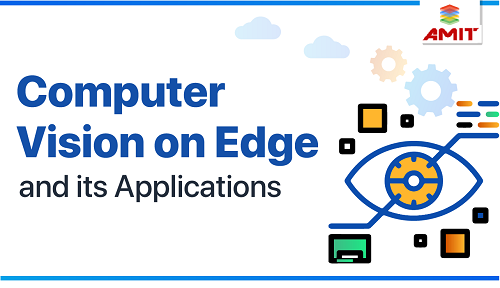

## This final project focuses on leveraging the techniques and concepts you've learned throughout this course. 
- You will apply image processing, feature extraction, and pattern recognition methods to solve real-world challenges. Specifically, you will implement and fine-tune state-of-the-art algorithms like Convolutional Neural Networks (CNNs), object detection, image segmentation, or even feature matching.

we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories

Data link : https://www.kaggle.com/puneet6060/intel-image-classification

#Import Libraries

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

#define the path ( to swtich it between jupyter notebook & kaggle kernel)

In [14]:
os.getcwd()
train_path='C:/Users\Gsamuel/Desktop\R-D-ML-vision/teamcvpy/data/Amit_Data/CV_project/seg_train/seg_train'
test_path='C:/Users/Gsamuel/Desktop/R-D-ML-vision/teamcvpy/data/Amit_Data/CV_project/seg_test/seg_test'
pred_path='C:/Users/Gsamuel/Desktop/R-D-ML-vision/teamcvpy\data/Amit_Data/CV_project/seg_pred/seg_pred'

# Open Folders

now let's first check the Train folder to have a look to its content

In [15]:
def count_images_in_folders(base_path, description):
    """
    Counts and prints the number of images in each folder within the specified base path.

    Parameters:
    - base_path: The path containing subfolders with images.
    - description: A string describing the type of data (e.g., 'training', 'testing', or 'prediction').
    """
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        images = gb.glob(os.path.join(folder_path, '*.jpg'))
        print(f'For {description} data, found {len(images)} images in folder "{folder}".')

# Count images in training, testing, and prediction data
count_images_in_folders(train_path, 'training')
count_images_in_folders(test_path, 'testing')
count_images_in_folders(pred_path, 'prediction')

For training data, found 2191 images in folder "buildings".
For training data, found 2271 images in folder "forest".
For training data, found 2404 images in folder "glacier".
For training data, found 2512 images in folder "mountain".
For training data, found 2274 images in folder "sea".
For training data, found 2382 images in folder "street".
For testing data, found 437 images in folder "buildings".
For testing data, found 474 images in folder "forest".
For testing data, found 553 images in folder "glacier".
For testing data, found 525 images in folder "mountain".
For testing data, found 510 images in folder "sea".
For testing data, found 501 images in folder "street".
For prediction data, found 0 images in folder "10004.jpg".
For prediction data, found 0 images in folder "10005.jpg".
For prediction data, found 0 images in folder "10012.jpg".
For prediction data, found 0 images in folder "10013.jpg".
For prediction data, found 0 images in folder "10017.jpg".
For prediction data, found 

#Checking Images
now we need to heck the images sizes , to know ow they looks like

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [16]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_code(n):
    for x,y in code.items():
        if n==y:
            return x
get_code(3)

'mountain'

In [17]:
def get_image_sizes(image_path, is_subfolder=False):
    """
    This function calculates the sizes of images in the given path.
    
    Parameters:
    - image_path: Path where images are stored.
    - is_subfolder: Set to True if the images are in subfolders (like train/test sets).
    
    Returns:
    - A pandas Series with the count of each image size.
    """
    sizes = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            images = gb.glob(pathname=str(image_path + '/' + folder + '/*.jpg'))
            for img in images:
                image = plt.imread(img)
                sizes.append(image.shape)
    else:
        files = gb.glob(pathname=str(image_path + '/*.jpg'))
        for file in files:
            image = plt.imread(file)
            sizes.append(image.shape)

    return pd.Series(sizes).value_counts()

# Usage examples
train_sizes = get_image_sizes(train_path, is_subfolder=True)
test_sizes = get_image_sizes(test_path, is_subfolder=True)
pred_sizes = get_image_sizes(pred_path, is_subfolder=False)

print("Train Image Sizes:\n", train_sizes)
print("Test Image Sizes:\n", test_sizes)
print("Prediction Image Sizes:\n", pred_sizes)

Train Image Sizes:
 (150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
dtype: int64
Test Image Sizes:
 (150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
dtype: int64
Prediction Image Sizes:
 (150, 150, 3)    7288

ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

#Reading Images
now it's time to read all images & convert it into arrays

first we'll create a variable s , which refer to size , so we can change it easily

let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

In [18]:
def load_images(image_path, code, resize_shape=(100, 100), is_subfolder=True):
    """
    Loads and resizes images from the specified path.
    
    Parameters:
    - image_path: Path where images are stored.
    - code: A dictionary mapping folder names to labels.
    - resize_shape: Tuple specifying the new size for resizing images (default is (100, 100)).
    - is_subfolder: Boolean indicating if images are in subfolders (True for train/test, False for prediction).
    
    Returns:
    - x_data: A NumPy array of resized images.
    - y_data: Corresponding labels (if applicable, else returns None for prediction data).
    """
    x_data = []
    y_data = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            folder_path = os.path.join(image_path, folder)
            images = gb.glob(pathname=os.path.join(folder_path, '*.jpg'))
            for img_path in images:
                image = plt.imread(img_path)  # Alternatively, you can use cv2.imread for BGR images
                image_resized = cv2.resize(image, resize_shape)
                x_data.append(image_resized)
                y_data.append(code[folder])  # Append the folder's label
    else:
        images = gb.glob(pathname=os.path.join(image_path, '*.jpg'))
        for img_path in images:
            image = cv2.imread(img_path)
            image_resized = cv2.resize(image, resize_shape)
            x_data.append(image_resized)
        y_data = None  # No labels for prediction data

    return np.array(x_data), np.array(y_data)

# Usage for train data
x_train, y_train = load_images(train_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for test data
x_test, y_test = load_images(test_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for prediction data (no labels)
x_pred, _ = load_images(pred_path, code=None, resize_shape=(100, 100), is_subfolder=False)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"x_pred shape: {x_pred.shape}")

x_train shape: (14034, 100, 100, 3), y_train shape: (14034,)
x_test shape: (3000, 100, 100, 3), y_test shape: (3000,)
x_pred shape: (7301, 100, 100, 3)


In [19]:
x_train=np.array(x_train)[:500]
x_test=np.array(x_test)[:500]

y_train=np.array(y_train)[:500]
y_test=np.array(y_test)[:500]

x_pred=np.array(x_pred)

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

print(x_pred.shape)

(500, 100, 100, 3)
(500, 100, 100, 3)
(500,)
(500,)
(7301, 100, 100, 3)


In [57]:
#implement same as vgg16
KerasModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(200, activation='tanh', kernel_size=(3,3), padding='same', input_shape=(100,100,3)),
    tf.keras.layers.Conv2D(180, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(160, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(140, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(120, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(100, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(80, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(60, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(140, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(120, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(50, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(40, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(40, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(30, activation='relu', kernel_size=(3,3), padding='same'),

    tf.keras.layers.Conv2D(20, activation='relu', kernel_size=(3,3), padding='same'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(30, activation='tanh'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [58]:
KerasModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [59]:

# Define the path where you want to save the best model
model_save_path = 'C:/Users/Gsamuel/Desktop/R-D-ML-vision/teamcvpy/Amit/Materails/5-AMIT_CV/Module_final_project_Report/project/model_weights/best_model.h5'  # Specify your desired path and filename

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)

# Train the model with the ModelCheckpoint callback
model = KerasModel.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),  # Make sure to include validation data
    epochs=1,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint]  # Pass the checkpoint callback here
)

8/8 [==============================] - ETA: 0s - loss: 0.5531 - accuracy: 0.8640 
Epoch 1: val_loss improved from inf to 0.60542, saving model to C:/Users/Gsamuel/Desktop/R-D-ML-vision/teamcvpy/Amit/Materails/5-AMIT_CV/Module_final_project_Report/project/model_weights\best_model.h5
8/8 [==============================] - 294s 37s/step - loss: 0.5531 - accuracy: 0.8640 - val_loss: 0.6054 - val_accuracy: 0.8740


In [61]:
loss,accuracy=KerasModel.evaluate(x_test,y_test)

16/16 [==============================] - 68s 4s/step - loss: 0.6054 - accuracy: 0.8740


In [62]:
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')

loss is 0.6054200530052185
accuracy is 0.8740000128746033


In [63]:
y_result = KerasModel.predict(x_pred)

y_result

229/229 [==============================] - 1026s 4s/step


array([[9.35913742e-01, 1.29650459e-02, 1.55426245e-02, 3.05917915e-02,
        4.17448673e-03, 8.12211714e-04],
       [9.35913861e-01, 1.29650477e-02, 1.55424783e-02, 3.05919033e-02,
        4.17459896e-03, 8.12209095e-04],
       [9.35913861e-01, 1.29650040e-02, 1.55426273e-02, 3.05917505e-02,
        4.17450722e-03, 8.12207931e-04],
       ...,
       [9.35913622e-01, 1.29651865e-02, 1.55422809e-02, 3.05918958e-02,
        4.17472934e-03, 8.12231330e-04],
       [9.35914040e-01, 1.29650384e-02, 1.55425919e-02, 3.05915959e-02,
        4.17456031e-03, 8.12204962e-04],
       [9.35913980e-01, 1.29650496e-02, 1.55426292e-02, 3.05916816e-02,
        4.17451980e-03, 8.12206825e-04]], dtype=float32)

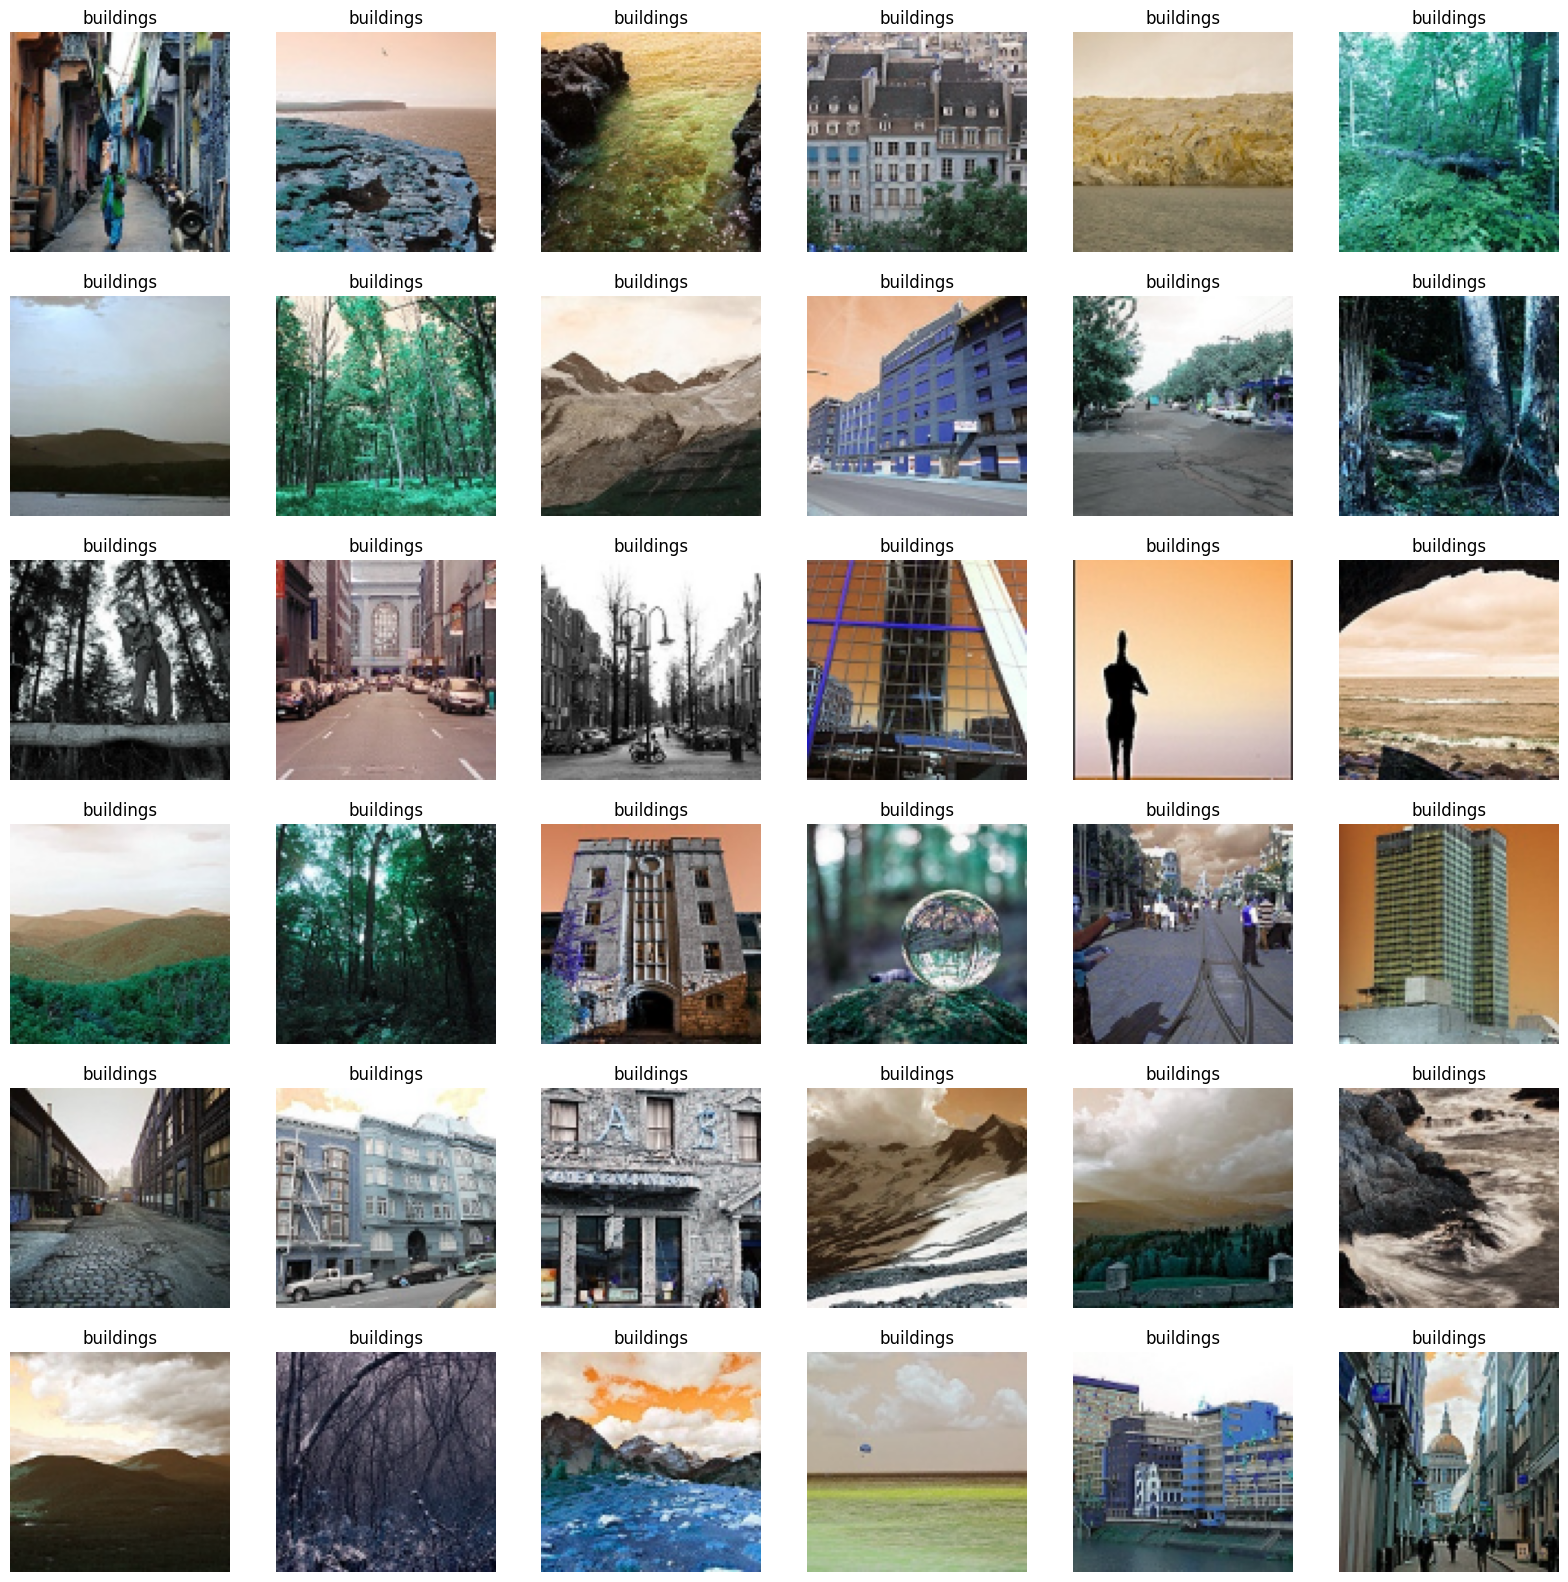

In [64]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_pred),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(x_pred[i])
    plt.axis('off')
    plt.title(get_code(np.argmax(y_result[i])))

In [65]:
y_pred = KerasModel.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

labels = list(code.values())
target_names = list(code.keys())
report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, labels=labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


16/16 [==============================] - 69s 4s/step
              precision    recall  f1-score   support

   buildings       0.87      1.00      0.93       437
      forest       0.00      0.00      0.00        63
     glacier       0.00      0.00      0.00         0
    mountain       0.00      0.00      0.00         0
         sea       0.00      0.00      0.00         0
      street       0.00      0.00      0.00         0

   micro avg       0.87      0.87      0.87       500
   macro avg       0.15      0.17      0.16       500
weighted avg       0.76      0.87      0.82       500

              precision    recall  f1-score   support

   buildings       0.87      1.00      0.93       437
      forest       0.00      0.00      0.00        63
     glacier       0.00      0.00      0.00         0
    mountain       0.00      0.00      0.00         0
         sea       0.00      0.00      0.00         0
      street       0.00      0.00      0.00         0

   micro avg       0.87 

c:\Users\Gsamuel\Desktop\R-D-ML-vision\teamcvpy\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gsamuel\Desktop\R-D-ML-vision\teamcvpy\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gsamuel\Desktop\R-D-ML-vision\teamcvpy\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

num_classes = 3
xx_train = np.array(x_train)[:500]
xx_test = np.array(x_test)[:500]
yy_train = to_categorical(np.array(y_train)[:500], num_classes=num_classes)
yy_test = to_categorical(np.array(y_test)[:500], num_classes=num_classes)

train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Create generators
train_generator = train_datagen.flow(
    xx_train,
    yy_train,
    batch_size=32
)

val_generator = val_datagen.flow(
    xx_test,
    yy_test,
    batch_size=32
)

In [48]:
def vgg16_architecture():
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.80)(x)

    output = Dense(num_classes, activation='softmax')(x)

    VGG16_model = Model(inputs=base_model.input, outputs=output)

    VGG16_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG16_model

In [49]:
def vgg19_architecture():
    from keras.applications import VGG19
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    from keras.layers import BatchNormalization, Dropout

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.80)(x)

    output = Dense(6, activation='softmax')(x)

    VGG19_model = Model(inputs=base_model.input, outputs=output)

    VGG19_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG19_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG19_model

In [50]:
def resnet152v2_architecture():
    from keras.applications import ResNet152V2
    base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    from keras.layers import BatchNormalization, Dropout

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.80)(x)

    output = Dense(6, activation='softmax')(x)

    ResNet152V2_model = Model(inputs=base_model.input, outputs=output)

    ResNet152V2_model.summary()

    optimizer = Adam(learning_rate=0.001)
    ResNet152V2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return ResNet152V2_model

In [51]:
def inception_v3_architecture():
    from keras.applications import InceptionV3
    
    from keras.layers import BatchNormalization, Dropout

    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.80)(x)

    output = Dense(6, activation='softmax')(x)

    InceptionV3_model = Model(inputs=base_model.input, outputs=output)

    InceptionV3_model.summary()

    optimizer = Adam(learning_rate=0.001)
    InceptionV3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return InceptionV3_model

In [52]:
def evaluate_model(model, x_test, yy_test):
    loss, accuracy = model.evaluate(x_test, yy_test)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    return loss, accuracy

    # cm = confusion_matrix(y_true, y_pred)
    # print("Confusion Matrix:")
    # print(cm)

    # cr = classification_report(y_true, y_pred, target_names=[f'class_{i}' for i in range(3)])
    # print("Classification Report:")
    # print(cr)

    # return cm, cr


 

In [68]:
models = {
     "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10  # Adjust epochs as needed
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

Training VGG16...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 2

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

def generate_confusion_matrix_and_metrics(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)
    
    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true), 
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = np.unique(y_true)
    target_names = [f'class_{label}' for label in labels]
    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

    return cm, report, precision, recall, f1_score


16/16 [==============================] - 31s 2s/step
y_pred shape: (500, 3)
y_test shape: (500,)
y_pred_classes shape: (500,)


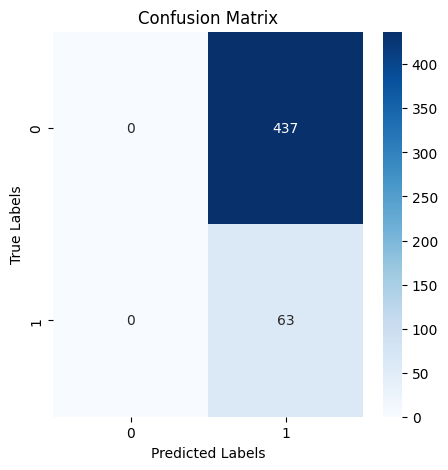

Classification Report:
              precision    recall  f1-score   support

     class_0       0.00      0.00      0.00       437
     class_1       0.13      1.00      0.22        63

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

Precision: 0.0159
Recall: 0.1260
F1-score: 0.0282


c:\Users\Gsamuel\Desktop\R-D-ML-vision\teamcvpy\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gsamuel\Desktop\R-D-ML-vision\teamcvpy\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gsamuel\Desktop\R-D-ML-vision\teamcvpy\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

(array([[  0, 437],
        [  0,  63]], dtype=int64),
 '              precision    recall  f1-score   support\n\n     class_0       0.00      0.00      0.00       437\n     class_1       0.13      1.00      0.22        63\n\n    accuracy                           0.13       500\n   macro avg       0.06      0.50      0.11       500\nweighted avg       0.02      0.13      0.03       500\n',
 0.015875999999999998,
 0.126,
 0.02819893428063943)

In [70]:
generate_confusion_matrix_and_metrics(model, x_test, y_test)

## In the code above, I have provided you with a written code, but it contains errors. Each of you must trace the errors and improve the accuracy for each model, recording the changes in the table below. Then, answer the following questions.

| Network          | Accuracy | Recall | Precision | F1-Score |
|------------------|----------|--------|-----------|----------|
| Your CNN model   |          |        |           |          |
| VGG16            |          |        |           |          |
| VGG19            |          |        |           |          |
| Inception_V3     |          |        |           |          |
| RasNet152V2      |          |        |           |          |
| DenseNet         |          |        |           |          |


# Experimental Results 